# Autoencoder

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import Model

## Visualisation

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def display(originals, autoencoder):
    rows = 28
    cols = 28
    transformed = autoencoder.predict(originals)
    
    fig, axs = plt.subplots(2, len(originals), figsize=(40, 10), subplot_kw={'xticks': [], 'yticks': []})
    
    for i, number in enumerate(originals):
        axs[0,i].imshow(number.reshape(rows, cols), cmap = matplotlib.cm.binary, interpolation='nearest')
    
    for i, number in enumerate(transformed):
        axs[1,i].imshow(number.reshape(rows, cols), cmap = matplotlib.cm.binary, interpolation='nearest')

    fig.tight_layout()
    plt.show()

## Naive Autoencoder

In [3]:
class NaiveEncoder(Layer):
    def __init__(self, hidden_dim):
        super(NaiveEncoder, self).__init__()
        self.hidden_layer = Dense(units = hidden_dim, activation='relu')
        self.output_layer = Dense(units = hidden_dim, activation='relu')
        
    def call(self, features):
        activation = self.hidden_layer(features)
        return self.output_layer(activation)


In [4]:
class NaiveDecoder(Layer):
    def __init__(self, hidden_dim, original_dim):
        super(NaiveDecoder, self).__init__()
        self.hidden_layer = Dense(units = hidden_dim, activation='relu')
        self.output_layer = Dense(units = original_dim, activation='relu')
        
    def call(self, features):
        activation = self.hidden_layer(features)
        return self.output_layer(activation)


In [5]:
class NaiveAutoencoder(Model):
    def __init__(self, hidden_dim, original_dim):
        super(NaiveAutoencoder, self).__init__()
        self.encoder = NaiveEncoder(hidden_dim)
        self.decoder = NaiveDecoder(hidden_dim, original_dim)
        
    def call(self, features):
        code = self.encoder(features)
        return self.decoder(code)

### Train and evaluate naive autoencoder

In [6]:
def prepare_data(features):
    features = features.astype('float32') / 255.0
    features = features.reshape(
        features.shape[0],
        features.shape[1] * features.shape[2])
    return features
(training_features, _), (test_features, _) = keras.datasets.mnist.load_data()

training_features = prepare_data(training_features)
test_features = prepare_data(test_features)

In [7]:
nautoencoder = NaiveAutoencoder(hidden_dim=64, original_dim = training_features.shape[1])
nautoencoder.compile(optimizer='rmsprop', loss='mse')

In [8]:
%%time

nautoencoder.fit(training_features,
                 training_features,
                 validation_data=(test_features, test_features),
                 epochs=10,
                 batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0359 - val_loss: 0.0244
Epoch 2/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0231 - val_loss: 0.0209
Epoch 3/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0199 - val_loss: 0.0183
Epoch 4/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0184 - val_loss: 0.0177
Epoch 5/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0175 - val_loss: 0.0157
Epoch 6/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0169 - val_loss: 0.0158
Epoch 7/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0164 - val_loss: 0.0161
Epoch 8/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0160 - val_loss: 0.0154
Epoch 9/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0157 - val_

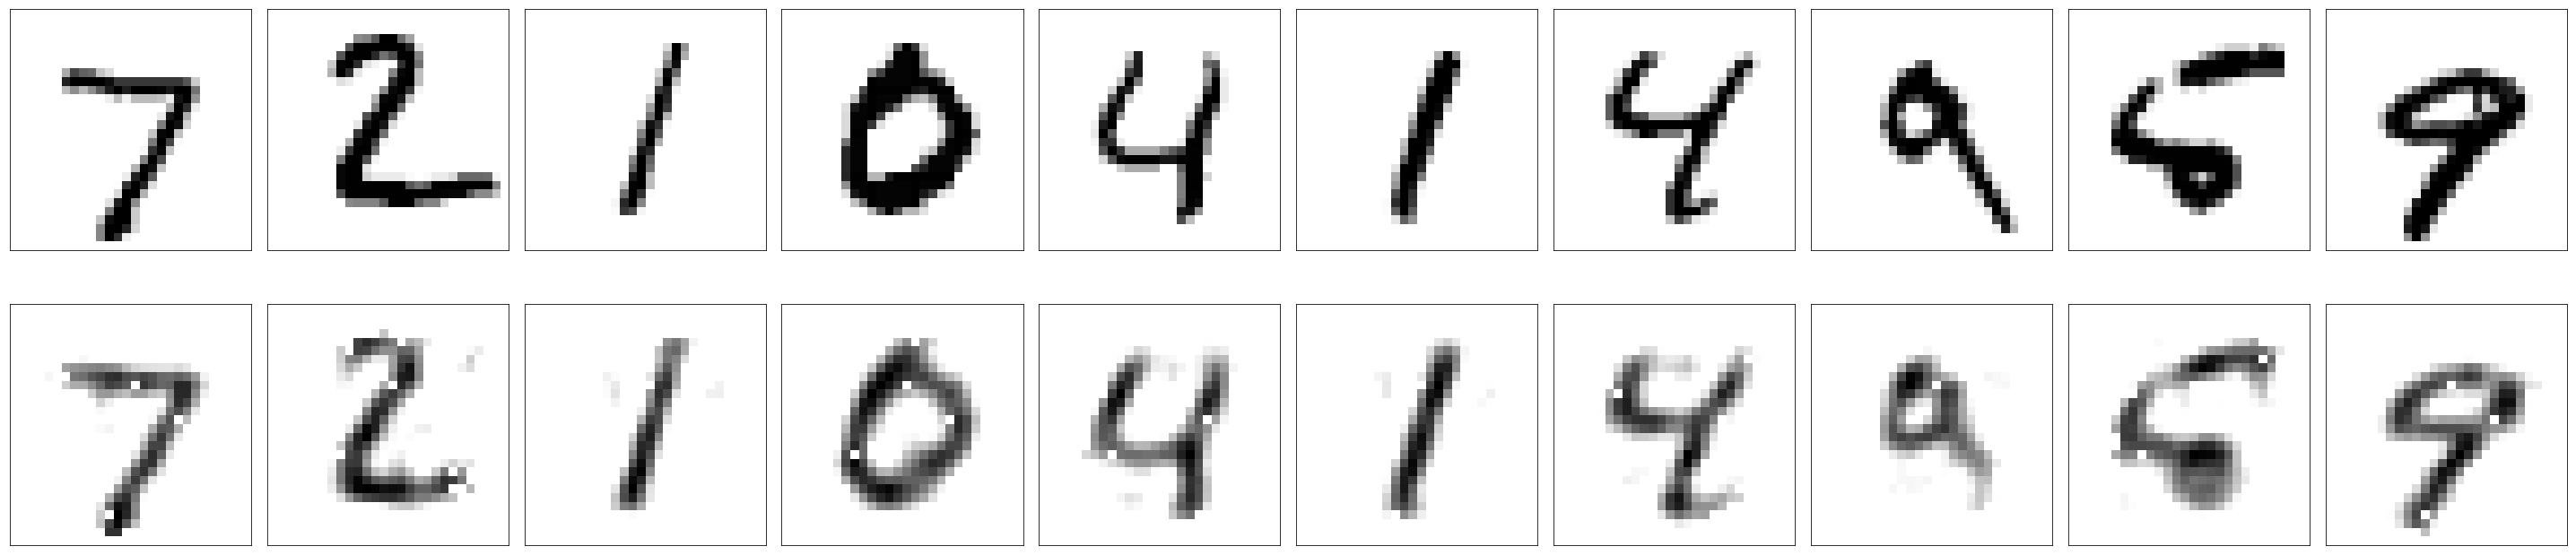

In [9]:
display(test_features[:10], nautoencoder)

## Convolutional Autoencoder

In [10]:
class ConvEncoder(Layer):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.layers = []
        self.layers.append( Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( MaxPooling2D((2, 2), padding='same') )
        self.layers.append( Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( MaxPooling2D((2, 2), padding='same') )
        self.layers.append( Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( MaxPooling2D((2, 2), padding='same') )
        
    def call(self, features):
        activation = features
        for layer in self.layers:
            activation = layer(activation)
        return activation

In [11]:
class ConvDecoder(Layer):
    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.layers = []
        self.layers.append( Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( UpSampling2D((2, 2)) )
        self.layers.append( Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( UpSampling2D((2, 2)) )
        self.layers.append( Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal') )
        self.layers.append( UpSampling2D((2, 2)) )
        self.layers.append( Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='glorot_normal') )
        
    def call(self, features):
        activation = features
        for layer in self.layers:
            activation = layer(activation)
        return activation

In [12]:
class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
        
    def call(self, features):
        code = self.encoder(features)
        return self.decoder(code)

### Train and evaluate convolutional autoencoder

In [13]:
def prepare_data(features):
    features = features.astype('float32') / 255.0
    return np.reshape(features, (len(features), 28, 28, 1))

(training_features, _), (test_features, _) = keras.datasets.mnist.load_data()
training_features = prepare_data(training_features)
test_features = prepare_data(test_features)

In [14]:
cautoencoder = ConvAutoencoder()
cautoencoder.compile(optimizer='rmsprop', loss='mse')

In [15]:
%%time

cautoencoder.fit(training_features,
                 training_features,
                 validation_data=(test_features, test_features),
                 epochs=10,
                 batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0505 - val_loss: 0.0340
Epoch 2/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0321 - val_loss: 0.0278
Epoch 3/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0275 - val_loss: 0.0269
Epoch 4/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0250 - val_loss: 0.0232
Epoch 5/10
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0232 - val_loss: 0.0220
Epoch 6/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0218 - val_loss: 0.0205
Epoch 7/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0206 - val_loss: 0.0196
Epoch 8/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0197 - val_loss: 0.0183
Epoch 9/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0189 - val_

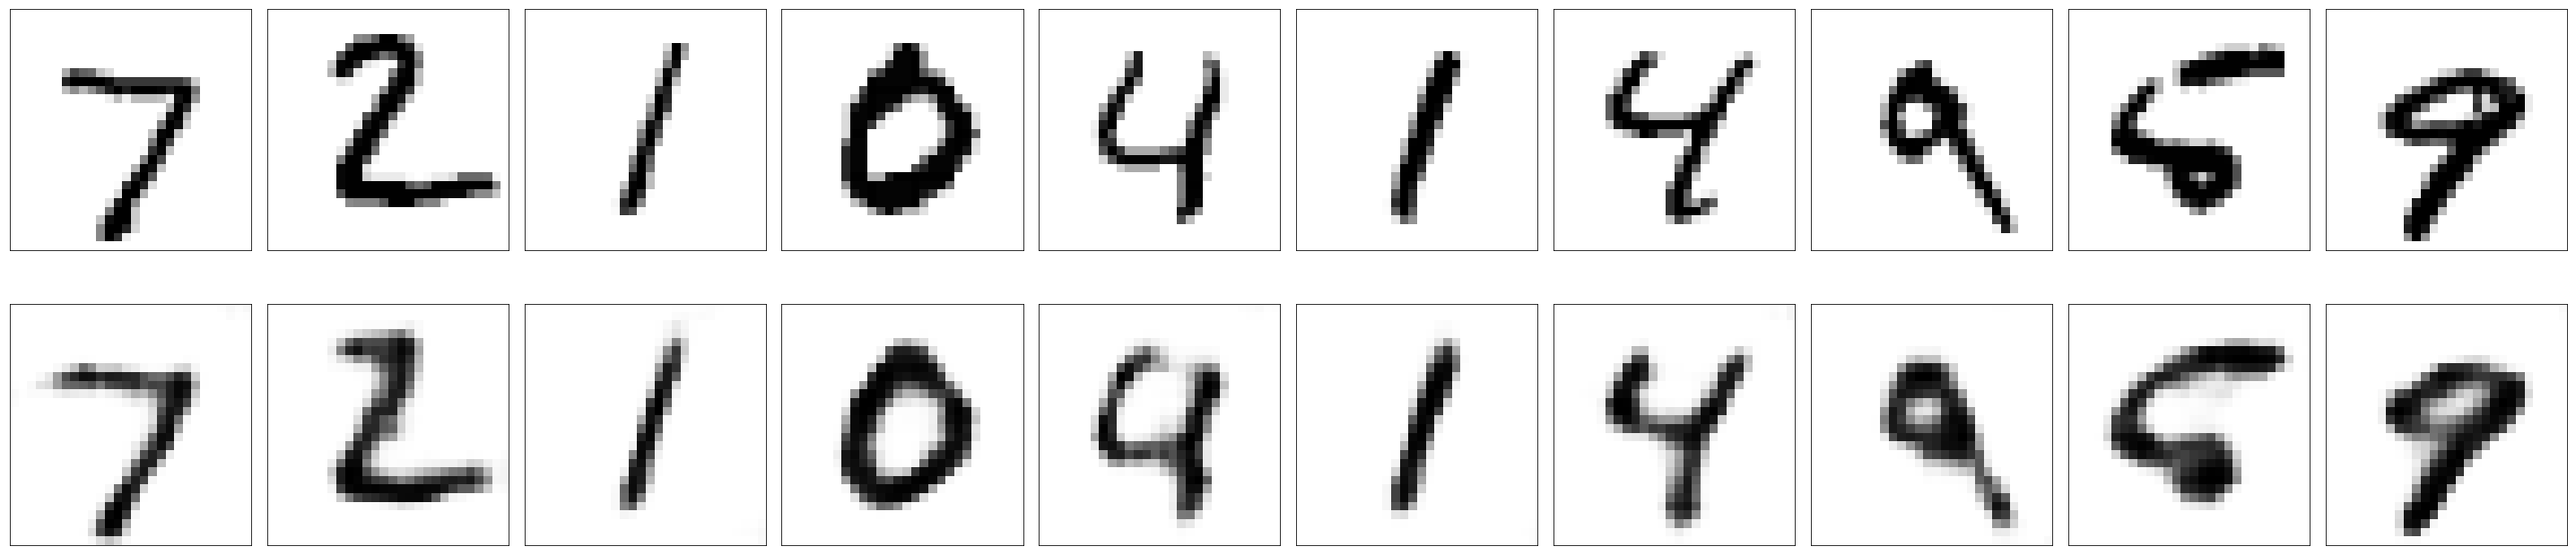

In [16]:
display(test_features[:10], cautoencoder)

## Image Denoising Autoencoder

In [17]:
class ImageDenoisingEncoder(Layer):
    def __init__(self):
        super(ImageDenoisingEncoder, self).__init__()
        self.layers = []
        self.layers.append( Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( MaxPooling2D((2, 2), padding='same') )
        self.layers.append( Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( MaxPooling2D((2, 2), padding='same') )
        
    def call(self, features):
        activation = features
        for layer in self.layers:
            activation = layer(activation)
        return activation

In [18]:
class ImageDenoisingDecoder(Layer):
    def __init__(self):
        super(ImageDenoisingDecoder, self).__init__()
        self.layers = []
        self.layers.append( Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( UpSampling2D((2, 2)) )
        self.layers.append( Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal') )
        self.layers.append( UpSampling2D((2, 2)) )
        self.layers.append( Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='glorot_normal') )
        
    def call(self, features):
        activation = features
        for layer in self.layers:
            activation = layer(activation)
        return activation

In [19]:
class ImageDenoisingAutoencoder(Model):
    def __init__(self):
        super(ImageDenoisingAutoencoder, self).__init__()
        self.encoder = ImageDenoisingEncoder()
        self.decoder = ImageDenoisingDecoder()
        
    def call(self, features):
        code = self.encoder(features)
        return self.decoder(code)

### Train and evaluate image denoising autoencoder

In [24]:
def prepare_data(features):
    features = features.astype('float32') / 255.0
    return np.reshape(features, (len(features), 28, 28, 1))

def add_noise(features, noise_factor = 0.3):
    return features + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=features.shape)

(training_features, _), (test_features, _) = keras.datasets.mnist.load_data()
training_features = prepare_data(training_features)
test_features = prepare_data(test_features)

training_features_noisy = add_noise(training_features)
test_features_noisy = add_noise(test_features)

In [27]:
idautoencoder = ImageDenoisingAutoencoder()
idautoencoder.compile(optimizer='rmsprop', loss='mse')

In [28]:
%%time

idautoencoder.fit(training_features_noisy,
                  training_features,
                  validation_data=(test_features_noisy, test_features),
                  epochs=3,
                  batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 156s 3ms/sample - loss: 0.0224 - val_loss: 0.0122
Epoch 2/3
60000/60000 [==============================] - 152s 3ms/sample - loss: 0.0101 - val_loss: 0.0089
Epoch 3/3
60000/60000 [==============================] - 149s 2ms/sample - loss: 0.0084 - val_loss: 0.0089
Wall time: 7min 37s


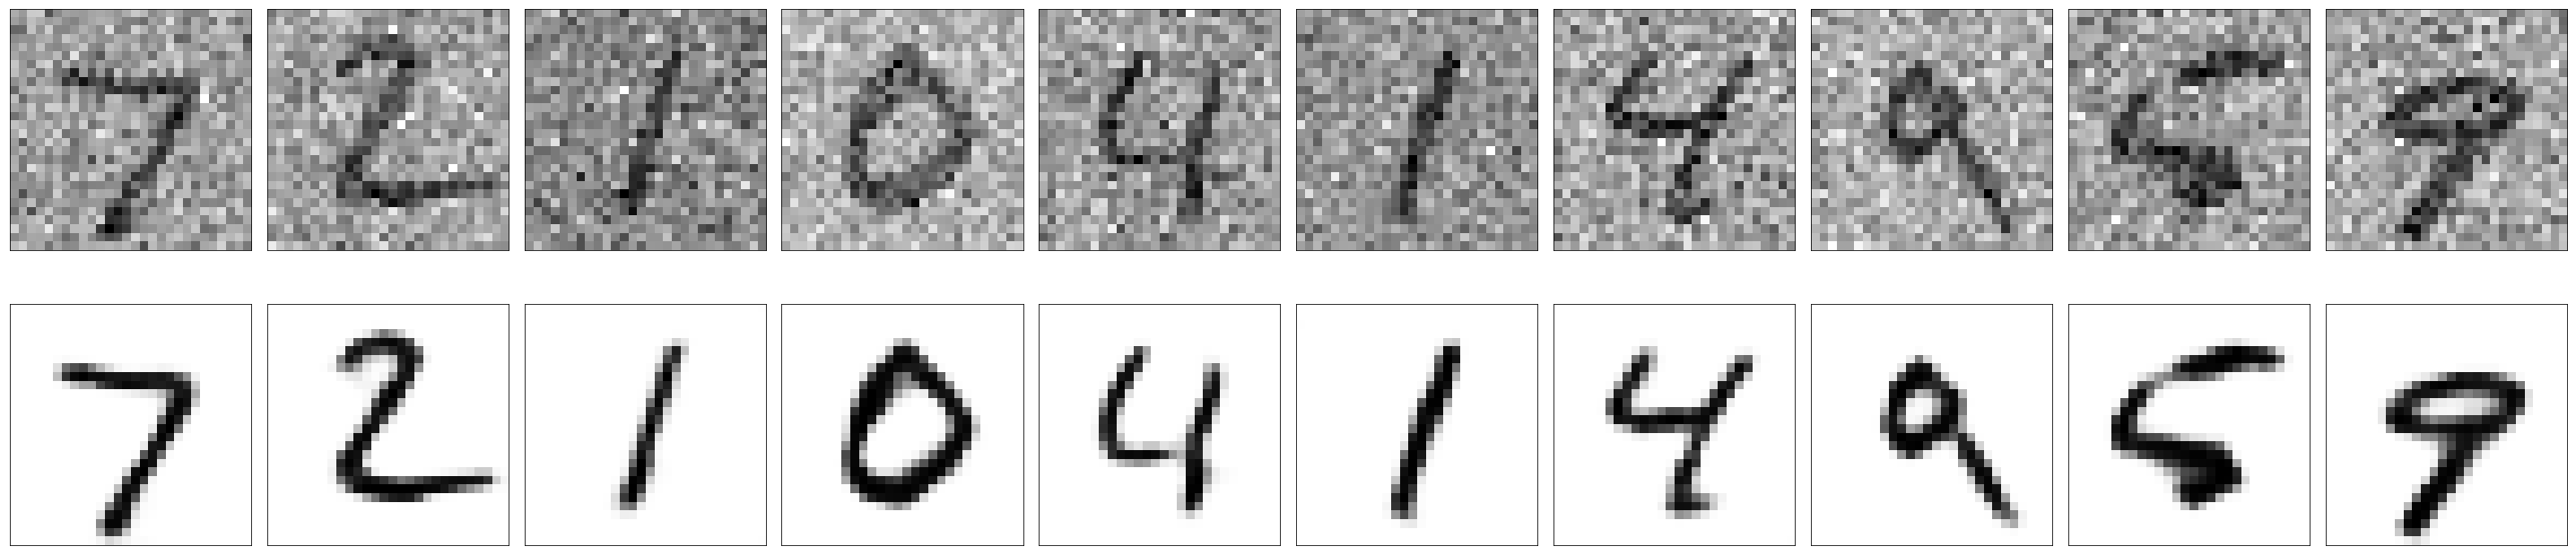

In [29]:
display(test_features_noisy[:10], idautoencoder)